### Dataset exploration

Aggregate Data

In [1]:
import pandas as pd
from glob import glob

# Load all daily CSVs into a single DataFrame
all_files = glob('../data/daily/http_day_2025-*.csv')
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

/tmp/ipykernel_3373570/253106967.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)


Basic Stats Table

In [2]:
summary = {
    'Total Requests': len(df),
    'Unique Client IPs': df['clientIP'].nunique(),
    'Unique Host IPs': df['hostIP'].nunique(),
    'Unique Countries (client)': df['client_country'].nunique(),
    'Unique Countries (host)': df['host_country'].nunique(),
    'Date Range': f"{df['startTime'].min()[:10]} — {df['startTime'].max()[:10]}"
}
print(pd.DataFrame(summary, index=['Stats']).T)


                                             Stats
Total Requests                            32894941
Unique Client IPs                           295094
Unique Host IPs                                271
Unique Countries (client)                      194
Unique Countries (host)                         25
Date Range                 2025-03-15 — 2025-10-15


#### Distribution Plots

In [3]:
country_counts = df['host_country'].value_counts().reset_index()
country_counts.columns = ['host_country', 'count']
country_counts.to_csv("../data/dataset/host_country_volume.csv", index=False)
print(" Exported to host_country_volume.csv")


 Exported to host_country_volume.csv


In [4]:
import pandas as pd
import pycountry

# Your data as a DataFrame
country_df = pd.read_csv("../data/dataset/host_country_volume.csv")  # columns: host_country,count

country_df['host_country'] = country_df['host_country'].replace({
    'The Netherlands': 'Netherlands'
})
# Function to map full country names to ISO2 codes
def country_to_iso2(name):
    try:
        return pycountry.countries.lookup(name).alpha_2
    except LookupError:
        return None

country_df["iso2"] = country_df["host_country"].apply(country_to_iso2)
country_df.to_csv("../data/dataset/host_country_volume.csv", index=False)
# Quick check for any that failed to map
print(country_df[country_df["iso2"].isnull()])

# Now use "iso2" for plotting or annotation if desired

Empty DataFrame
Columns: [host_country, count, iso2]
Index: []


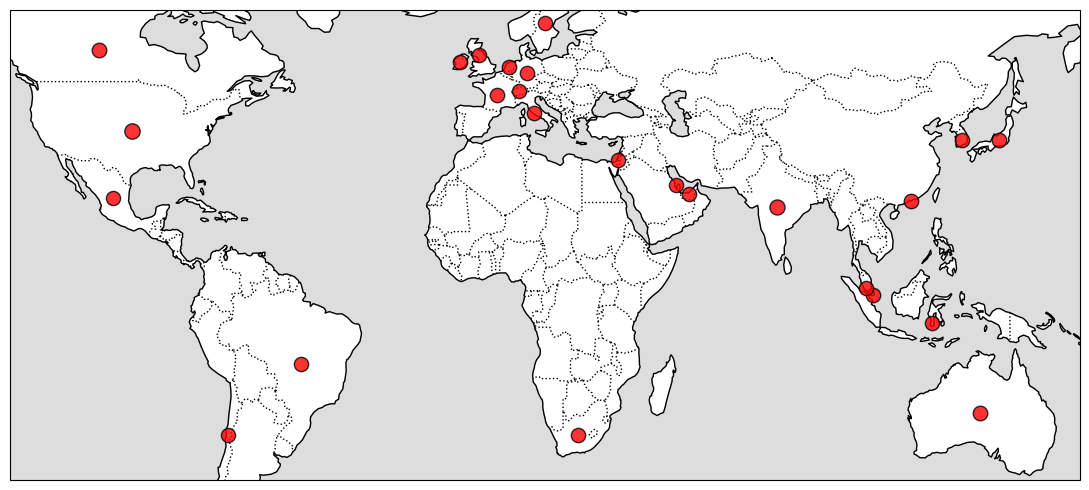

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# 1. Country centroid dictionary
coords = {
    'US': (38, -97), 'IN': (21, 78), 'JP': (36, 138), 'CA': (56, -106), 'AU': (-25, 133),
    'IT': (42, 12), 'HK': (22.3, 114.2), 'FR': (46, 2), 'SG': (1.3, 103.8), 'ZA': (-30, 24),
    'DE': (51, 10), 'KR': (36, 128), 'GB': (55, -3), 'NL': (52.2, 5.3), 'IE': (53.3, -8),
    'ID': (-5, 120), 'SE': (62, 15), 'IL': (31.5, 34.75), 'AE': (24, 54), 'BR': (-14, -51),
    'BH': (26, 50.5), 'MY': (3, 102), 'CH': (47, 8), 'CL': (-30, -71), 'MX': (23, -102),
}

# 2. Load your CSV
df = pd.read_csv("../data/dataset/host_country_volume.csv")

# 3. Set up plot settings
fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, 160, -40, 65], crs=ccrs.PlateCarree())
ax.set_aspect('auto')
ax.add_feature(cfeature.LAND, color='white', zorder=0)
ax.add_feature(cfeature.OCEAN, color='#DDDDDD', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

base_size = 10
scale = 0.00035

# 4. Plot dots for each country
for _, row in df.iterrows():
    iso = row['iso2']
    count = row['count']
    if iso in coords:
        lat, lon = coords[iso]
        dot_size = base_size + scale * np.sqrt(count)
        ax.plot(
            lon, lat, marker='o', markersize=dot_size,
            color='red', markeredgecolor='black', alpha=0.8,
            transform=ccrs.PlateCarree()
        )

#plt.title("Global Honeypot Infrastructure Distribution", fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("../data/dataset/infrageo.pdf", bbox_inches="tight")
plt.show()


In [6]:
df.head()

,host_country,count,iso2
0,United States,8773005,US
1,India,5695172,IN
2,Canada,1864316,CA
3,Australia,1696078,AU
4,Japan,1593329,JP
